# Visualize Various NAE Training Methods

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from models.modules import FCNet, IsotropicGaussian, FCResNet
from models.ae import AE, VAE
from models.nae import NAE
from loaders.synthetic import sample2d

In [6]:
device = 'cpu:0'

In [7]:
dset = '8gaussians'
if dset == '8gaussians':
    xmin, xmax, ymin, ymax = [-4, 4, -4, 4]
elif dset == '2spirals':
    xmin, xmax, ymin, ymax = [-4, 4, -4, 4]
elif dset == 'checkerboard':
    xmin, xmax, ymin, ymax = [-4, 4, -4, 4]


In [8]:
XX, YY = torch.meshgrid(torch.linspace(xmin, xmax, 100), torch.linspace(ymin,ymax, 100))
grid = torch.cat([XX.reshape(-1,1), YY.reshape(-1,1)], dim=1)
grid_gpu = grid
grid_gpu = grid.to(device)

# PCD No Restart

In [14]:
# zdim = 3
# encoder = FCResNet(2, zdim, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
# decoder = FCResNet(zdim, 2, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
# nae = NAE(encoder, decoder, sampling='x',
#            x_step=50, x_stepsize=None, x_noise_std=0.05, x_bound=(-5, 5), x_clip_langevin_grad=None,
#            z_step=None, z_stepsize=None, z_noise_std=None, z_bound=None,
#            gamma=1, spherical=False,
#            temperature=0.1, temperature_trainable=True,
#            l2_norm_reg=None, l2_norm_reg_en=None, z_norm_reg=0.01,
#            initial_dist='uniform', replay=True, replay_ratio=1., buffer_size=200,
#            mh=True)

# x = torch.rand((1,2)).to(device)
# nae._set_x_shape(x)
# nae._set_z_shape(x)

# nae.load_state_dict(torch.load('nae_pcdnore_3_8gaussians.pth'))

<All keys matched successfully>

In [36]:
# E = nae.energy_T(grid_gpu).detach().cpu().reshape(100, 100)
# # E = nae.energy(grid_gpu).detach().cpu().reshape(100, 100)
# Omega = ((8 / 100 * 8 / 100) * np.exp(-E)).sum()
# p_pcdnore = np.exp(-E.T)/Omega

# PCD 5% Restart

In [29]:
zdim = 3
encoder = FCResNet(2, zdim, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
decoder = FCResNet(zdim, 2, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
nae = NAE(encoder, decoder, sampling='x',
           x_step=50, x_stepsize=None, x_noise_std=0.05, x_bound=(-5, 5), x_clip_langevin_grad=None,
           z_step=None, z_stepsize=None, z_noise_std=None, z_bound=None,
           gamma=1, spherical=False,
           sigma=0.5, sigma_trainable=True,
           temperature=0.1, temperature_trainable=True,
           l2_norm_reg=None, l2_norm_reg_en=None, z_norm_reg=0.01,
           initial_dist='uniform', replay=True, replay_ratio=0.95, buffer_size=10000,
           deterministic=True, mh=True)

x = torch.rand((1,2)).to(device)
nae._set_x_shape(x)
nae._set_z_shape(x)

nae.load_state_dict(torch.load('nae_pcd_3_8gaussians.pth'))

<All keys matched successfully>

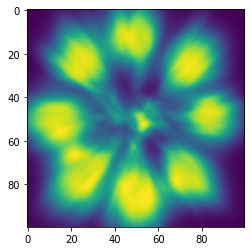

In [22]:
E = nae.energy_T(grid_gpu).detach().cpu().reshape(100, 100)
Omega = ((8 / 100 * 8 / 100) * np.exp(-E)).sum()
p_pcd = np.exp(-E.T)/Omega
plt.imshow(p_pcd)

# CD

In [20]:
zdim = 3
encoder = FCResNet(2, zdim, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
decoder = FCResNet(zdim, 2, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
nae = NAE(encoder, decoder, sampling='cd',
           x_step=5, x_stepsize=None, x_noise_std=0.05, x_bound=(-5, 5), x_clip_langevin_grad=None,
           z_step=None, z_stepsize=None, z_noise_std=None, z_bound=None,
           gamma=1, spherical=False,
           temperature=0.1, temperature_trainable=True,
           l2_norm_reg=None, l2_norm_reg_en=None, z_norm_reg=0.01,
           initial_dist='uniform', replay=False, replay_ratio=0.95, buffer_size=10000,
           mh=True)

x = torch.rand((1,2)).to(device)
nae._set_x_shape(x)
nae._set_z_shape(x)

nae.load_state_dict(torch.load('nae_cd_3_8gaussians.pth'))

<All keys matched successfully>

In [21]:
E = nae.energy_T(grid_gpu).detach().cpu().reshape(100, 100)
Omega = ((8 / 100 * 8 / 100) * np.exp(-E)).sum()
p_cd = np.exp(-E.T)/Omega

# On-manifold

In [24]:
zdim = 3
encoder = FCResNet(2, zdim, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
decoder = FCResNet(zdim, 2, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
nae = NAE(encoder, decoder, sampling='on_manifold',
           x_step=30, x_stepsize=None, x_noise_std=0.1, x_bound=(-5, 5), x_clip_langevin_grad=None,
           z_step=10, z_stepsize=None, z_noise_std=0.1, z_bound=None, z_clip_langevin_grad=None,
           gamma=1, spherical=False,
           temperature=0.1, temperature_trainable=True,
           l2_norm_reg=None, l2_norm_reg_en=None, z_norm_reg=0.01,
           initial_dist='gaussian', replay=True, replay_ratio=0.95, buffer_size=10000,
           mh=True, mh_z=False, reject_boundary=True, reject_boundary_z=True)

x = torch.rand((1,2)).to(device)
nae._set_x_shape(x)
nae._set_z_shape(x)

nae.load_state_dict(torch.load('nae_3_8gaussians.pth'))

<All keys matched successfully>

In [25]:
E = nae.energy_T(grid_gpu).detach().cpu().reshape(100, 100)
Omega = ((8 / 100 * 8 / 100) * np.exp(-E)).sum()
p_om = np.exp(-E.T)/Omega

In [26]:
nae.z_step = 500
d_sample = nae.sample(n_sample=100, device='cpu', replay=False)
sample_om = d_sample['sample_x']

# 8 Gaussians

In [27]:
from torch.distributions import Normal

In [28]:
g1 = Normal(torch.tensor([4/np.sqrt(2),0]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))
g2 = Normal(torch.tensor([-4/np.sqrt(2),0]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))
g3 = Normal(torch.tensor([0,4/np.sqrt(2)]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))
g4 = Normal(torch.tensor([0,-4/np.sqrt(2)]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))
g5 = Normal(torch.tensor([2,2]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))
g6 = Normal(torch.tensor([-2,2]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))
g7 = Normal(torch.tensor([2,-2]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))
g8 = Normal(torch.tensor([-2,-2]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))

In [29]:
p1 = torch.exp(g1.log_prob(grid).sum(dim=1))
p2 = torch.exp(g2.log_prob(grid).sum(dim=1))
p3 = torch.exp(g3.log_prob(grid).sum(dim=1))
p4 = torch.exp(g4.log_prob(grid).sum(dim=1))
p5 = torch.exp(g5.log_prob(grid).sum(dim=1))
p6 = torch.exp(g6.log_prob(grid).sum(dim=1))
p7 = torch.exp(g7.log_prob(grid).sum(dim=1))
p8 = torch.exp(g8.log_prob(grid).sum(dim=1))

In [30]:
p_8gaussian = (p1 + p2 + p3 + p4 + p5+ p6+ p7 + p8) / 8

In [31]:
p_max = p_8gaussian.max()

In [33]:
batch_size = 200
batch_x = torch.tensor(sample2d(dset, batch_size=batch_size), dtype=torch.float32)

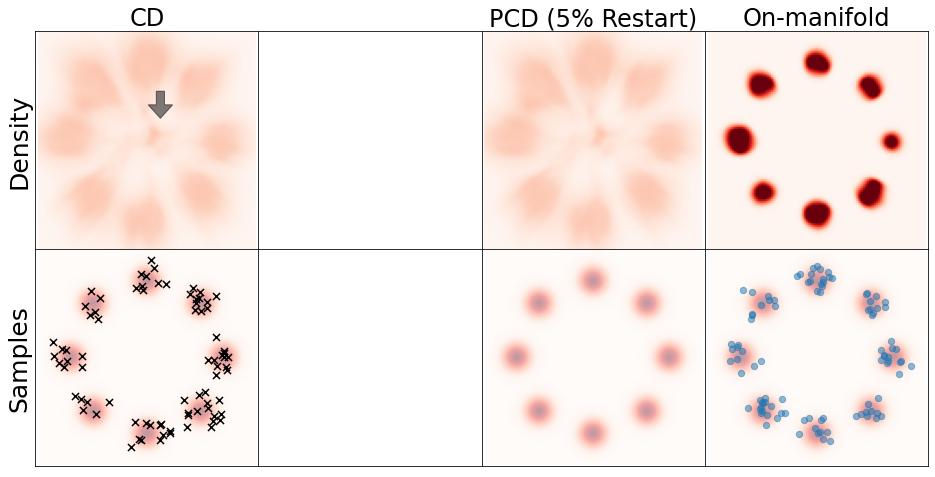

In [38]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)


ax = axs[0,0]
ax.imshow(p_cd, origin='lower', extent=(-4, 4, -4, 4), cmap='Reds', vmin=0, vmax=p_max)
ax.arrow(0.5, 1.8, 0., -0.5, width=0.3, head_length=0.5, color='k', alpha=0.5)
ax.axis('equal')
ax.set_xticks([]); ax.set_yticks([])
ax.set_title('CD')
ax.set_ylabel('Density', fontsize=25)
ax = axs[1,0]
ax.imshow(p_8gaussian.reshape(100,100), origin='lower', extent=(-4, 4, -4, 4), cmap='Reds', vmin=0, alpha=0.4)
ax.set_xticks([]); ax.set_yticks([])
n_samples = 80
ax.scatter(batch_x[:n_samples,0], batch_x[:n_samples,1], c='k', s=50, marker='x')
# ax.scatter(sample_cd[:n_samples,0], sample_cd[:n_samples,1], c='C0', s=40, alpha=0.5)
ax.set_ylabel('Samples', fontsize=25)
ax.axis('equal')


ax = axs[0,1]
# ax.imshow(p_pcdnore, origin='lower', extent=(-4, 4, -4, 4), cmap='Reds', vmin=0, vmax=p_max)
ax.set_xticks([]); ax.set_yticks([])
# ax.set_title('PCD (No Restart)')
# ax.axis('equal')

ax = axs[1,1]
# ax.imshow(p_8gaussian.reshape(100,100), origin='lower', extent=(-4, 4, -4, 4), cmap='Reds', vmin=0, alpha=0.4)
ax.set_xticks([]); ax.set_yticks([])
# ax.axis('equal')



ax = axs[0,2]
ax.imshow(p_pcd, origin='lower', extent=(-4, 4, -4, 4), cmap='Reds', vmin=0, vmax=p_max)
ax.set_xticks([]); ax.set_yticks([])
ax.set_title('PCD (5% Restart)')
ax.axis('equal')
ax = axs[1,2]
ax.imshow(p_8gaussian.reshape(100,100), origin='lower', extent=(-4, 4, -4, 4), cmap='Reds', vmin=0, alpha=0.4)
ax.set_xticks([]); ax.set_yticks([])
ax.axis('equal')

ax = axs[0,3]
im = ax.imshow(p_om, origin='lower', extent=(-4, 4, -4, 4), cmap='Reds', vmin=0, vmax=p_max)
ax.set_xticks([]); ax.set_yticks([])
ax.set_title('On-manifold')
ax.axis('equal')
# plt.colorbar(im, ax=ax)
ax = axs[1,3]
ax.imshow(p_8gaussian.reshape(100,100), origin='lower', extent=(-4, 4, -4, 4), cmap='Reds', vmin=0, alpha=0.4)
ax.set_xticks([]); ax.set_yticks([])
ax.scatter(sample_om[:,0], sample_om[:,1], s=40, alpha=0.5)
ax.axis('equal')
# plt.tight_layout(pad=0.)
fig.subplots_adjust(wspace=0,hspace=0)
plt.savefig('fig_training_methods.pdf', bbox_inches='tight')